In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar la base limpia que generamos en la etapa de limpieza
#    Nota: df_cleaned.csv debe estar en la misma carpeta del script/notebook
df = pd.read_csv("df_cleaned.csv")

Shape del dataset: (20827, 105)

Primeras filas del dataset:
   host_since  host_response_time  host_response_rate  host_acceptance_rate  \
0  2019-12-14  within a few hours                 100                  54.0   
1  2013-01-19        within a day                  90                  69.0   
2  2019-09-16  within a few hours                  75                 100.0   
3  2014-04-29        Sin registro                 100                  60.0   
4  2013-07-25  a few days or more                   0                   0.0   

    latitude  longitude  accommodates  bathrooms  bathrooms_text  bedrooms  \
0  40.746980 -73.917630             1        1.0   1 shared bath       1.0   
1  40.721470 -73.982700             1        2.0  2 shared baths       1.0   
2  40.682300 -73.845450             6        1.0          1 bath       2.0   
3  40.713163 -73.943077             1        1.0   1 shared bath       2.0   
4  40.674120 -73.941230             6        4.0         4 baths       3.0

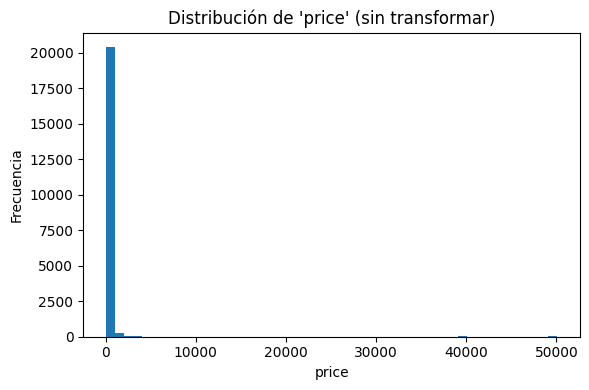

In [ ]:
# Revisar tamaño del dataset (filas, columnas) para tener una idea del orden de magnitud
print("Shape del dataset:", df.shape)

# Ver las primeras filas para confirmar que las columnas corresponden a lo esperado
print("\nPrimeras filas del dataset:")
print(df.head())

# Revisar tipos de datos para tener claro qué es numérico, categórico, etc.
print("\nResumen de tipos de datos:")
print(df.dtypes)

# Descripción básica de la variable objetivo original 'price'
#    Esto ayuda a ver rangos, promedio, percentiles, etc.
print("\nDescripción estadística de 'price':")
print(df["price"].describe())

# Histograma de 'price' sin transformar
#    La idea es visualizar la distribución cruda y ver si está muy sesgada
plt.figure(figsize=(6, 4))
plt.hist(df["price"], bins=50)
plt.title("Distribución de 'price' (sin transformar)")
plt.xlabel("price")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Percentil 1 de price: 37.0
Percentil 99 de price: 1910.0
Shape después de filtrar outliers de price: (20436, 105)

Descripción de 'log_price':
count    20436.000000
mean         5.073405
std          0.768963
min          3.610918
25%          4.499810
50%          5.030438
75%          5.598422
max          7.554859
Name: log_price, dtype: float64


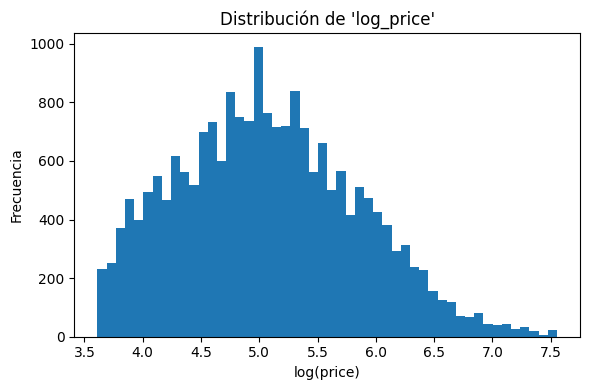

In [4]:
# Filtro simple de outliers de 'price' usando percentiles
p1 = df["price"].quantile(0.01)
p99 = df["price"].quantile(0.99)

print(f"Percentil 1 de price: {p1}")
print(f"Percentil 99 de price: {p99}")

# Me quedo con precios dentro de este rango para evitar valores extremos muy raros
df_model1 = df[(df["price"] >= p1) & (df["price"] <= p99)].copy()

print("Shape después de filtrar outliers de price:", df_model1.shape)

# Creo la variable objetivo transformada: logaritmo natural del precio
df_model1["log_price"] = np.log(df_model1["price"])

print("\nDescripción de 'log_price':")
print(df_model1["log_price"].describe())

# Histograma de log_price para ver que la distribución queda más razonable
plt.figure(figsize=(6, 4))
plt.hist(df_model1["log_price"], bins=50)
plt.title("Distribución de 'log_price'")
plt.xlabel("log(price)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Defino las columnas numéricas "básicas" que quiero usar directamente
base_feature_cols = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "amenities_count",
    "minimum_nights",
    "maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost:t",
    "has_tv",
    "has_wifi",
    "has_hot_water",
    "has_air_conditioning",
    "has_heating",
    "has_refrigerator",
    "has_kitchen",
    "has_pets_allowed",
    "has_coffee_maker",
    "has_dishes_and_silverware",
    "has_essentials",
    "has_free_parking",
    "has_email",
    "has_phone",
]

# Verifico que todas estas columnas existan en df_model1
missing_cols = [col for col in base_feature_cols if col not in df_model1.columns]
print("Columnas base faltantes (si hay):", missing_cols)

# Además de las numéricas básicas, incluyo las dummies de ubicación y tipo:
dummy_prefixes = [
    "neighbourhood_group_cleansed:",
    "room_type:",
    "property_type:",
    "instant_bookable:",
]

dummy_cols = [
    col for col in df_model1.columns
    if any(col.startswith(pref) for pref in dummy_prefixes)
]

print(f"Número de columnas dummy incluidas: {len(dummy_cols)}")

# Construyo la lista final de columnas de X
feature_cols = [col for col in base_feature_cols if col in df_model1.columns] + dummy_cols

print(f"Total de columnas en X: {len(feature_cols)}")

# Matriz de features y vector objetivo
X = df_model1[feature_cols].copy()
y = df_model1["log_price"].copy()

# Por seguridad, elimino filas con algún NaN en X o en y
data_model = pd.concat([X, y], axis=1).dropna()
X = data_model[feature_cols]
y = data_model["log_price"]

print("Shape final de X, y después de eliminar posibles NaN:")
print(X.shape, y.shape)

# Partición train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Columnas base faltantes (si hay): []
Número de columnas dummy incluidas: 70
Total de columnas en X: 96
Shape final de X, y después de eliminar posibles NaN:
(20436, 96) (20436,)
Shape X_train: (16348, 96)
Shape X_test: (4088, 96)
Shape y_train: (16348,)
Shape y_test: (4088,)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Entreno el modelo de mínimos cuadrados ordinarios
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones en train y test
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Métricas en escala log
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Desempeño en TRAIN (escala log_price):")
print(f"R2:   {r2_train:.3f}")
print(f"RMSE: {rmse_train:.3f}")
print(f"MAE:  {mae_train:.3f}")

print("\nDesempeño en TEST (escala log_price):")
print(f"R2:   {r2_test:.3f}")
print(f"RMSE: {rmse_test:.3f}")
print(f"MAE:  {mae_test:.3f}")

# Opcional: ver también el error en la escala original del precio
y_test_pred_price = np.exp(y_test_pred)
y_test_real_price = np.exp(y_test)

rmse_price = np.sqrt(mean_squared_error(y_test_real_price, y_test_pred_price))
mae_price = mean_absolute_error(y_test_real_price, y_test_pred_price)

print("\nDesempeño en TEST (escala de price original):")
print(f"RMSE (price): {rmse_price:.2f}")
print(f"MAE (price):  {mae_price:.2f}")

Desempeño en TRAIN (escala log_price):
R2:   0.625
RMSE: 0.470
MAE:  0.367

Desempeño en TEST (escala log_price):
R2:   0.626
RMSE: 0.473
MAE:  0.369

Desempeño en TEST (escala de price original):
RMSE (price): 155.44
MAE (price):  82.75


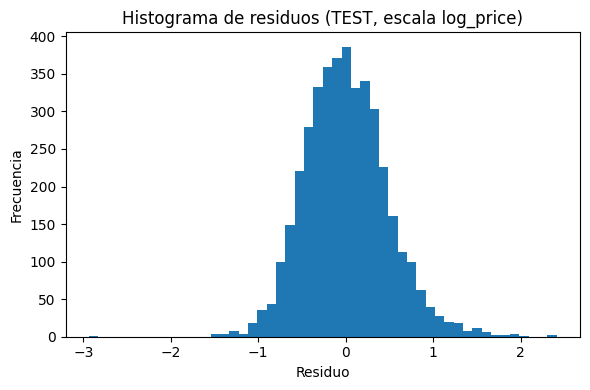

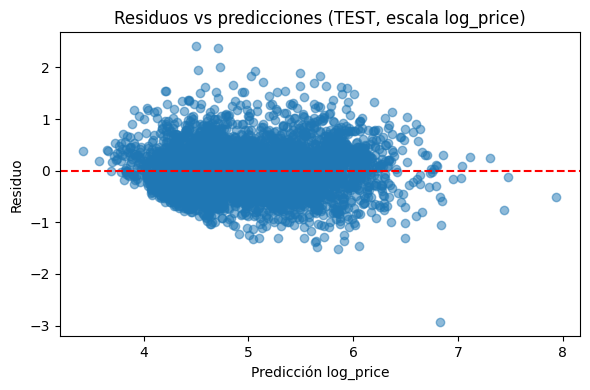

In [7]:
# Residuos en train y test (escala log)
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Histograma de residuos en test
plt.figure(figsize=(6, 4))
plt.hist(residuals_test, bins=50)
plt.title("Histograma de residuos (TEST, escala log_price)")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Residuos vs predicciones en test
plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred, residuals_test, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuos vs predicciones (TEST, escala log_price)")
plt.xlabel("Predicción log_price")
plt.ylabel("Residuo")
plt.tight_layout()
plt.show()

In [8]:
import joblib

# Construyo un DataFrame con coeficientes y nombres de variables
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": lin_reg.coef_
})

# Ordeno por valor absoluto del coeficiente para ver las variables más influyentes
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False)

print("Top 20 variables con mayor impacto (en valor absoluto) sobre log_price:")
print(coef_df.head(20)[["feature", "coef"]])

# Opcional: guardo la tabla de coeficientes a un CSV para usarla en el reporte
coef_df.to_csv("modelo1_coeficientes.csv", index=False)

# Guardo el modelo entrenado en disco para reutilizarlo en otras etapas (tablero, etc.)
joblib.dump(lin_reg, "modelo1_regresion_lineal.pkl")

print("\nModelo guardado en 'modelo1_regresion_lineal.pkl'")
print("Coeficientes guardados en 'modelo1_coeficientes.csv'")

Top 20 variables con mayor impacto (en valor absoluto) sobre log_price:
                                             feature      coef
79      property_type:Shared room in casa particular -1.200683
48                           property_type:Houseboat  1.137459
69  property_type:Private room in serviced apartment -0.917368
68              property_type:Private room in resort  0.816136
57                property_type:Private room in dorm -0.758270
54              property_type:Private room in castle -0.655364
32                                property_type:Boat  0.633986
47                        property_type:Entire villa  0.593260
67         property_type:Private room in rental unit -0.522727
50   property_type:Private room in bed and breakfast -0.517926
41                         property_type:Entire loft  0.490393
74                  property_type:Room in aparthotel  0.472825
60          property_type:Private room in guesthouse -0.434733
72       property_type:Private room in vacatio